## Goal

Run the app-water-body-cloud-native.1.0.0.cwl released application package using calrissian, a CWL runner for kubernetes and exploit the usage report.

## Lab

This step has a dedicated lab available at /workspace/mastering-app-package/practice-labs/Kubernetes/benchmark.ipynb


In [1]:
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import json
import logging
import unittest
from io import StringIO
from pathlib import Path
from calrissian.context import CalrissianLoadingContext, CalrissianRuntimeContext
from calrissian.executor import ThreadPoolJobExecutor
from calrissian.k8s import delete_pods
from calrissian.main import (
    activate_logging,
    add_arguments,
    flush_tees,
    install_signal_handler,
)
from calrissian.report import (
    CPUParser,
    MemoryParser,
    Reporter,
    initialize_reporter,
    default_serializer,
)
from calrissian.version import version
from cwltool.argparser import arg_parser
from cwltool.main import main as cwlmain
from nose2.tools import params
import uuid
from cwltool.load_tool import fetch_document

## Step 1 Create a Benchmark python class

This Benchmark python class takes the application package parameters and the pair max cores/max ram.

It will generate a benchmark report that can be analyzed to generate plots and tables

In [2]:
class Benchmark():

    def __init__(self, aoi, epsg, stac_items, bands, max_cores, max_ram):

        self.level = logging.INFO

        self.cwl_url = "https://github.com/Terradue/app-package-training-bids23/releases/download/1.0.0/app-water-bodies-cloud-native.1.0.0.cwl"

        self.tmp_outdir_prefix = "/calrissian/tmp"
        self.outdir = "/calrissian/out"

        self.parser = arg_parser()

        self.aoi = aoi 
        self.epsg = epsg 
        self.stac_items = stac_items
        self.bands = bands 
        self.max_cores = max_cores
        self.max_ram = max_ram

    def get_cli_args(self):

        cli_args = [
            "--tmp-outdir-prefix",
            self.tmp_outdir_prefix,
            "--outdir",
            self.outdir,
            f"{self.cwl_url}#water-bodies.cwl",
            f"--aoi={self.aoi}",
            f"--epsg={self.epsg}"
        ]

        for stac_item in self.stac_items:
            cli_args.append(f"--stac_items={stac_item}")

        for band in self.bands:
            cli_args.append(f"--band={band}")

        return cli_args

    def run(self):

        parsed_args = self.parser.parse_args(
            self.get_cli_args()
        )

        results, usage = self.run_calrissian(
            parsed_args=parsed_args
        )

        _, workflowobj, uri = fetch_document(self.cwl_url)

        result = {}

        result["application_package"] = {"uri": uri, "cwl": workflowobj}
        result["results"] = results
        result["usage"] = usage
        result["parameters"] = {
            "stac_items": self.stac_items,
            "aoi": self.aoi,
            "epsg": self.epsg,
            "bands": self.bands,
        }

        return result


    def run_calrissian(self, parsed_args):

        max_ram_megabytes = MemoryParser.parse_to_megabytes(self.max_ram)
        max_cores = CPUParser.parse(self.max_cores)
        executor = ThreadPoolJobExecutor(max_ram_megabytes, max_cores)
        initialize_reporter(max_ram_megabytes, max_cores)

        runtime_context = CalrissianRuntimeContext(vars(parsed_args))
        runtime_context.select_resources = executor.select_resources

        install_signal_handler()

        stream_out = StringIO()

        try:

            res = cwlmain(
                args=parsed_args,
                stdout=stream_out,
                executor=executor,
                loadingContext=CalrissianLoadingContext(),
                runtimeContext=runtime_context,
                versionfunc=version,
                logger_handler=logging.FileHandler("empty.log"),
            )
        finally:
            delete_pods()

        assert res == 0

        return json.loads(stream_out.getvalue()), Reporter.get_report().to_dict()

    


## Step 2 run the benchmark

In [10]:
benchmark = Benchmark(stac_items=[
                "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20210708_0_L2A",
                "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_10TFK_20210713_0_L2A",
                "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20210718_0_L2A",
                "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20220524_0_L2A",
                "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20220514_0_L2A",
                "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20220504_0_L2A",
            ],
            aoi="-121.399,39.834,-120.74,40.472",
            epsg="EPSG:4326",
            bands=["green", "nir"],
            max_cores="20",
            max_ram="128G")


In [11]:
report = benchmark.run()

## Step 3 analyze the report

Plot a Gantt chart of the workflow steps.

In [13]:


def plot_usage(report):
    usage = report["usage"]
    cwl = report["application_package"]["cwl"]

    color_mapping = {}
    for elem in cwl["$graph"]:

        if elem["class"] in ["CommandLineTool"]:
            color_mapping[elem["id"]] = (
                random.uniform(0, 1),
                random.uniform(0, 1),
                random.uniform(0, 1),
            )

    tasks = [step["name"] for step in usage["children"]]

    node_colors = [
        color_mapping.get("crop")
        if "crop" in task
        else color_mapping.get("norm_diff")
        if "norm_diff" in task
        else color_mapping.get("otsu")
        if "otsu" in task
        else color_mapping.get("stac", [0, 0, 0])
        for task in tasks
    ]

    # Step 2: Create the data for the Gantt chart

    start_dates = [step["start_time"] for step in usage["children"]]
    durations = [step["elapsed_seconds"] for step in usage["children"]]

    # Step 3: Initialize the figure and axis
    fig, ax = plt.subplots()

    # Step 4: Set y-axis tick labels
    ax.set_yticks(np.arange(len(tasks)))
    ax.set_yticklabels(tasks)

    # Step 5: Plot each task as a horizontal bar
    for index, task in enumerate(tasks):
        start_date = pd.to_datetime(start_dates[index])
        end_date = start_date + pd.DateOffset(seconds=durations[index])
        ax.barh(
            index,
            end_date - start_date,
            left=start_date,
            height=0.5,
            align="center",
            color=node_colors[index],
        )

    # Step 6: Set x-axis limits
    min_date = pd.to_datetime(min(start_dates))
    max_date = pd.to_datetime(max(start_dates)) + pd.DateOffset(seconds=max(durations))
    ax.set_xlim(min_date, max_date)

    # Step 7: Customize the chart
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%dT%H:%M:%S"))
    ax.set_xlabel("Date")
    ax.set_ylabel("Steps")
    ax.set_title("Calrissian execution report")

    # Step 8: Display the chart
    plt.grid(True)
    plt.show()

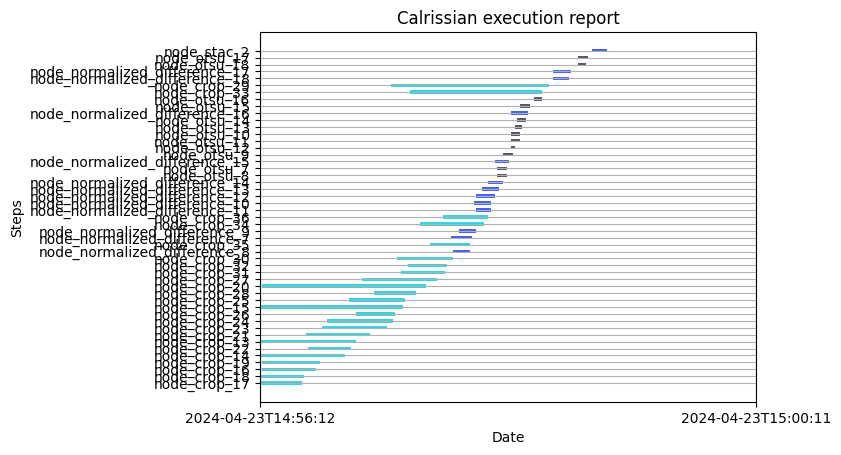

In [14]:
plot_usage(report)

Generate the tabular data

In [8]:
usage_df = pd.DataFrame.from_dict(report["usage"]["children"])

usage_df

,cpus,ram_megabytes,disk_megabytes,exit_code,name,start_time,finish_time,elapsed_hours,elapsed_seconds,ram_megabyte_hours,cpu_hours
0,1.0,536.870912,87.602514,0,node_crop,2024-04-23 14:49:27+00:00,2024-04-23 14:49:47+00:00,0.005556,20.0,2.982616,0.005556
1,1.0,536.870912,86.936548,0,node_crop_7,2024-04-23 14:49:27+00:00,2024-04-23 14:49:49+00:00,0.006111,22.0,3.280878,0.006111
2,1.0,536.870912,100.225105,0,node_crop_8,2024-04-23 14:49:27+00:00,2024-04-23 14:49:49+00:00,0.006111,22.0,3.280878,0.006111
3,1.0,536.870912,100.150064,0,node_crop_4,2024-04-23 14:49:27+00:00,2024-04-23 14:49:53+00:00,0.007222,26.0,3.877401,0.007222
4,1.0,536.870912,88.893808,0,node_crop_5,2024-04-23 14:49:27+00:00,2024-04-23 14:49:57+00:00,0.008333,30.0,4.473924,0.008333
5,1.0,536.870912,87.481912,0,node_crop_3,2024-04-23 14:49:19+00:00,2024-04-23 14:50:07+00:00,0.013333,48.0,7.158279,0.013333
6,1.0,536.870912,87.387690,0,node_crop_9,2024-04-23 14:49:50+00:00,2024-04-23 14:50:10+00:00,0.005556,20.0,2.982616,0.005556
7,1.0,536.870912,227.071185,0,node_normalized_difference,2024-04-23 14:50:03+00:00,2024-04-23 14:50:11+00:00,0.002222,8.0,1.193046,0.002222
8,1.0,536.870912,97.473672,0,node_crop_10,2024-04-23 14:49:52+00:00,2024-04-23 14:50:15+00:00,0.006389,23.0,3.430009,0.006389
9,1.0,536.870912,89.932939,0,node_crop_11,2024-04-23 14:49:53+00:00,2024-04-23 14:50:20+00:00,0.007500,27.0,4.026532,0.007500


In [15]:
import copy

overall_report = copy.deepcopy(report["usage"])

del overall_report["children"]


pd.DataFrame.from_dict([overall_report])

,cores_allowed,ram_mb_allowed,start_time,finish_time,elapsed_hours,elapsed_seconds,total_cpu_hours,total_ram_megabyte_hours,total_disk_megabytes,total_tasks,max_parallel_cpus,max_parallel_ram_megabytes,max_parallel_tasks
0,20.0,128000.0,2024-04-23 14:56:12+00:00,2024-04-23 14:58:59+00:00,0.046389,167.0,0.272222,146.148193,4981.424124,49,8.0,4294.967296,8
